In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Audio bias of HC
HC_bias_a = np.zeros((3, 8))
# HC_bias_a[0]--High; HC_bias_a[1]--Medium; HC_bias_a[2]--Low
HC_bias_a[0] = np.array(
    [
        -5.21640112246667,
        -4.18706601266667,
        -3.13696911613333,
        -2.09924748133333,
        1.35796414540000,
        3.07563797893333,
        3.81842299133333,
        3.35914483333333,
    ]
)
HC_bias_a[1] = np.array(
    [
        -4.65343309471429,
        -5.46053503785714,
        -2.09086371792857,
        -1.13832656671429,
        -0.277120626642857,
        0.262638716714286,
        2.19984634542857,
        3.40839929092857,
    ]
)
HC_bias_a[2] = np.array(
    [
        -2.93714767620000,
        -2.81604437300000,
        -1.61590862560000,
        -1.98143368426667,
        -1.29873315480000,
        0.0165255805333333,
        0.501353158466667,
        1.16135676946667,
    ]
)

In [3]:
# Causal Inference of HC
HC_pro_com = np.array(
    [
        [
            0.367025484375000,
            0.682562911541667,
            0.822405755208334,
            0.876760716875000,
            0.863113007208333,
            0.809197201583333,
            0.649743997500000,
            0.321256356083333,
        ],
        [
            0.435277895916667,
            0.621660267583333,
            0.659722209500000,
            0.704617010791667,
            0.724928494125000,
            0.687408309375000,
            0.612227719333333,
            0.446587043833333,
        ],
        [
            0.519254406291667,
            0.624221809791667,
            0.623241935666667,
            0.633213512666667,
            0.650625944875000,
            0.645931453375000,
            0.608952192000000,
            0.537992153875000,
        ],
    ]
)

In [4]:
from scipy.optimize import differential_evolution
from skneuromsi.sweep import ParameterSweep

dis = np.array([-24, -12, -6, -3, 3, 6, 12, 24])  # disparities
bias_data = 1 - np.abs(HC_bias_a[0]) / np.abs(dis)
causes_data = HC_pro_com[0]

## Alais and Burr


In [9]:
from skneuromsi.mle import AlaisBurr2004


def alais_job(a_sigma, v_sigma):
    model = AlaisBurr2004(position_range=(0, 90), position_res=1)
    sp = ParameterSweep(
        model=model, target="visual_position", repeat=1, n_jobs=1, range=45 + dis
    )
    res = sp.run(
        auditory_position=45, visual_sigma=v_sigma, auditory_sigma=a_sigma, noise=False
    )
    bias = res.bias.bias_mean(
        influence_parameter="auditory_position", mode="multi", quiet=True
    )
    return bias.values


def alais_cost(theta):
    model_data = alais_job(theta[0], theta[1])
    exp_data = bias_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48)]
alais_fit_res = differential_evolution(
    alais_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)
print(alais_fit_res)

differential_evolution step 1: f(x)= 9.10868
differential_evolution step 2: f(x)= 9.10868
differential_evolution step 3: f(x)= 9.10868
differential_evolution step 4: f(x)= 9.10868
differential_evolution step 5: f(x)= 9.10868
differential_evolution step 6: f(x)= 9.10868
differential_evolution step 7: f(x)= 9.10868
differential_evolution step 8: f(x)= 9.10868
differential_evolution step 9: f(x)= 9.10868
differential_evolution step 10: f(x)= 9.10868
differential_evolution step 11: f(x)= 9.10868
differential_evolution step 12: f(x)= 9.10868
differential_evolution step 13: f(x)= 9.10868
differential_evolution step 14: f(x)= 9.10868
differential_evolution step 15: f(x)= 9.10868
differential_evolution step 16: f(x)= 9.10868
 message: Optimization terminated successfully.
 success: True
     fun: 9.10867669723244
       x: [ 1.204e+01  1.191e+01]
     nit: 16
    nfev: 510


Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

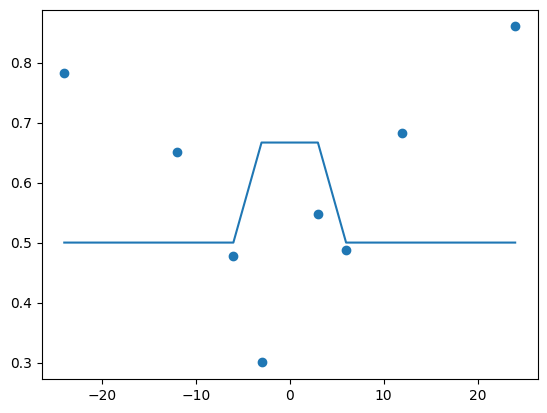

In [10]:
alais_model_fit = alais_job(alais_fit_res.x[0], alais_fit_res.x[1])

plt.plot(dis, alais_model_fit)
plt.scatter(dis, bias_data)

## Kording

In [11]:
from skneuromsi.bayesian import Kording2007


def kording_job(a_sigma, v_sigma, p_mu, p_sigma):
    model = Kording2007(position_range=(0, 90), position_res=1)
    sp = ParameterSweep(
        model=model, target="visual_position", repeat=1, n_jobs=1, range=45 + dis
    )
    res = sp.run(
        auditory_position=45,
        visual_sigma=v_sigma,
        auditory_sigma=a_sigma,
        noise=False,
        prior_mu=p_mu,
        prior_sigma=p_sigma,
        strategy="averaging",
    )
    bias = res.bias.bias_mean(
        influence_parameter="auditory_position", mode="auditory", quiet=True
    )
    return bias.values


def kording_cost(theta):
    model_data = kording_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = bias_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (21, 69), (0.1, 48)]
kording_fit_res = differential_evolution(
    kording_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)
print(kording_fit_res)

differential_evolution step 1: f(x)= 11.4004
differential_evolution step 2: f(x)= 11.4004
differential_evolution step 3: f(x)= 11.4004
differential_evolution step 4: f(x)= 10.4711
differential_evolution step 5: f(x)= 10.4711
differential_evolution step 6: f(x)= 10.1887
differential_evolution step 7: f(x)= 9.37552
differential_evolution step 8: f(x)= 9.37552
differential_evolution step 9: f(x)= 8.89122
differential_evolution step 10: f(x)= 8.77517
differential_evolution step 11: f(x)= 8.77517
differential_evolution step 12: f(x)= 8.67377
differential_evolution step 13: f(x)= 8.67377
differential_evolution step 14: f(x)= 8.67377
differential_evolution step 15: f(x)= 8.67377
differential_evolution step 16: f(x)= 8.67377
differential_evolution step 17: f(x)= 8.67377
differential_evolution step 18: f(x)= 8.67377
differential_evolution step 19: f(x)= 8.67377
differential_evolution step 20: f(x)= 8.67377
differential_evolution step 21: f(x)= 8.67377
differential_evolution step 22: f(x)= 8.547

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

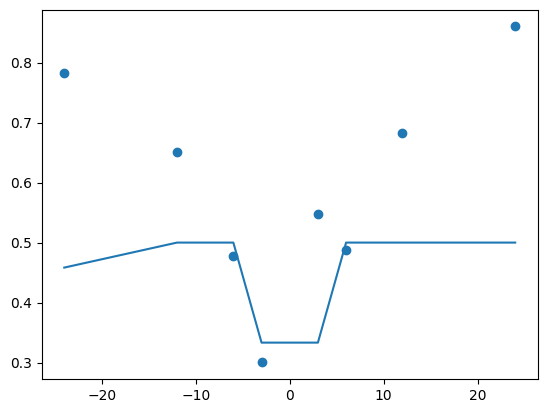

In [12]:
kording_model_fit = kording_job(
    kording_fit_res.x[0],
    kording_fit_res.x[1],
    kording_fit_res.x[2],
    kording_fit_res.x[3],
)

plt.plot(dis, kording_model_fit)
plt.scatter(dis, bias_data)

In [15]:
def kording_causes_job(a_sigma, v_sigma):
    model = Kording2007(position_range=(0, 90), position_res=1)
    sp = ParameterSweep(
        model=model, target="visual_position", repeat=1, n_jobs=1, range=45 + dis
    )
    res = sp.run(
        auditory_position=45,
        visual_sigma=v_sigma,
        auditory_sigma=a_sigma,
        noise=False,
        prior_mu=45,
        prior_sigma=20,
        strategy="selection",
    )
    causes = res.causes.unity_report()
    return causes.values


def kording_causes_cost(theta):
    model_data = kording_causes_job(theta[0], theta[1])
    exp_data = causes_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48)]
kording_causes_fit_res = differential_evolution(
    kording_causes_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=-1,
    polish=False,
)
print(kording_causes_fit_res)

differential_evolution step 1: f(x)= 64.3685
differential_evolution step 2: f(x)= 64.2764
differential_evolution step 3: f(x)= 64.2764
differential_evolution step 4: f(x)= 64.1842
differential_evolution step 5: f(x)= 64.1842
 message: Optimization terminated successfully.
 success: True
     fun: 64.1842474836019
       x: [ 1.937e+00  1.262e+00]
     nit: 5
    nfev: 180


Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

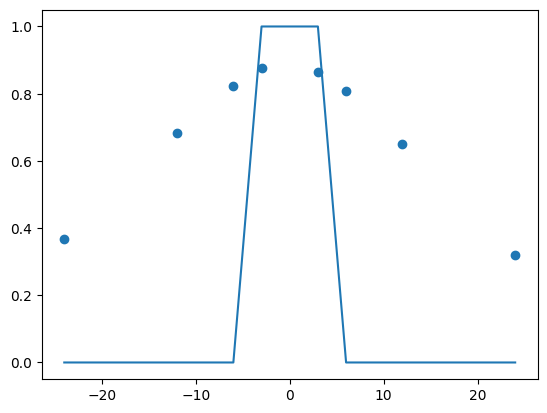

In [16]:
kording_model_causes_fit = kording_causes_job(
    kording_causes_fit_res.x[0], kording_causes_fit_res.x[1]
)

plt.plot(dis, kording_model_causes_fit)
plt.scatter(dis, causes_data)

## Cuppini 2017

In [14]:
from skneuromsi.neural import Cuppini2017


def cuppini2017_job(a_sigma, v_sigma, a_intensity, v_intensity):
    biases = []
    a_pos = 45
    model = Cuppini2017(neurons=90, position_range=(0, 90), position_res=1)
    for v_pos in a_pos + dis:
        res = model.run(
            visual_position=v_pos,
            auditory_position=a_pos,
            visual_sigma=v_sigma,
            auditory_sigma=a_sigma,
            noise=False,
            auditory_intensity=a_intensity,
            visual_intensity=v_intensity,
        )
        max_time = res.to_xarray()["times"].max().values
        estimated_a_pos = (
            res.get_modes("auditory").query("times==@max_time").values.argmax()
        )
        bias = np.absolute(estimated_a_pos - a_pos) / np.absolute(a_pos - v_pos)
        biases.append(bias)
    return np.array(biases)


def cuppini2017_cost(theta):
    model_data = cuppini2017_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = bias_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (0.1, 30), (0.1, 30)]
cuppini2017_fit_res = differential_evolution(
    cuppini2017_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)
print(cuppini2017_fit_res)

differential_evolution step 1: f(x)= 1.41513
differential_evolution step 2: f(x)= 1.15347
differential_evolution step 3: f(x)= 1.15347
differential_evolution step 4: f(x)= 1.15347
differential_evolution step 5: f(x)= 1.15347
differential_evolution step 6: f(x)= 1.15347
differential_evolution step 7: f(x)= 1.12322
differential_evolution step 8: f(x)= 0.88228
differential_evolution step 9: f(x)= 0.88228
differential_evolution step 10: f(x)= 0.88228
differential_evolution step 11: f(x)= 0.88228
differential_evolution step 12: f(x)= 0.88228
differential_evolution step 13: f(x)= 0.88228
differential_evolution step 14: f(x)= 0.777356
differential_evolution step 15: f(x)= 0.524763
differential_evolution step 16: f(x)= 0.524763
differential_evolution step 17: f(x)= 0.524763
differential_evolution step 18: f(x)= 0.524763
differential_evolution step 19: f(x)= 0.408182
differential_evolution step 20: f(x)= 0.365436
differential_evolution step 21: f(x)= 0.365436
differential_evolution step 22: f(x

25
39
42
44
46
48
51
65


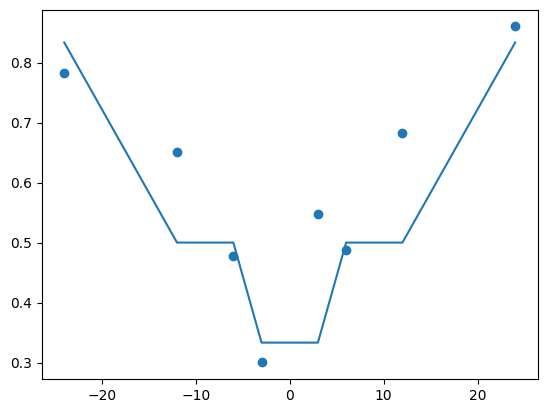

In [18]:
cuppini2017_model_fit = cuppini2017_job(
    cuppini2017_fit_res.x[0],
    cuppini2017_fit_res.x[1],
    cuppini2017_fit_res.x[2],
    cuppini2017_fit_res.x[3],
)

plt.plot(dis, cuppini2017_model_fit)
plt.scatter(dis, bias_data)

In [5]:
from skneuromsi.neural import Cuppini2017


def cuppini2017_causes_job(a_sigma, v_sigma, a_intensity, v_intensity):
    causes = []
    a_pos = 45
    model = Cuppini2017(neurons=90, position_range=(0, 90), position_res=1)
    for v_pos in a_pos + dis:
        res = model.run(
            visual_position=v_pos,
            auditory_position=a_pos,
            visual_sigma=v_sigma,
            auditory_sigma=a_sigma,
            noise=False,
            causes_kind="prob",
            auditory_intensity=a_intensity,
            visual_intensity=v_intensity,
        )
        causes.append(res.causes_)
    return np.array(causes)


def cuppini2017_causes_cost(theta):
    model_data = cuppini2017_causes_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = causes_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (0.1, 30), (0.1, 30)]
cuppini2017_causes_fit_res = differential_evolution(
    cuppini2017_causes_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=-1,
    polish=False,
)
print(cuppini2017_causes_fit_res)

differential_evolution step 1: f(x)= 0.192849
differential_evolution step 2: f(x)= 0.192849
differential_evolution step 3: f(x)= 0.192849
differential_evolution step 4: f(x)= 0.14573
differential_evolution step 5: f(x)= 0.14573
differential_evolution step 6: f(x)= 0.125072
differential_evolution step 7: f(x)= 0.125072
differential_evolution step 8: f(x)= 0.125072
differential_evolution step 9: f(x)= 0.125072
differential_evolution step 10: f(x)= 0.125072
differential_evolution step 11: f(x)= 0.125072
differential_evolution step 12: f(x)= 0.0254829
differential_evolution step 13: f(x)= 0.0254829
differential_evolution step 14: f(x)= 0.0254829
differential_evolution step 15: f(x)= 0.0203048
differential_evolution step 16: f(x)= 0.0174151
differential_evolution step 17: f(x)= 0.0174151
differential_evolution step 18: f(x)= 0.0174151
differential_evolution step 19: f(x)= 0.0174151
differential_evolution step 20: f(x)= 0.0174151
differential_evolution step 21: f(x)= 0.0174151
differential_e

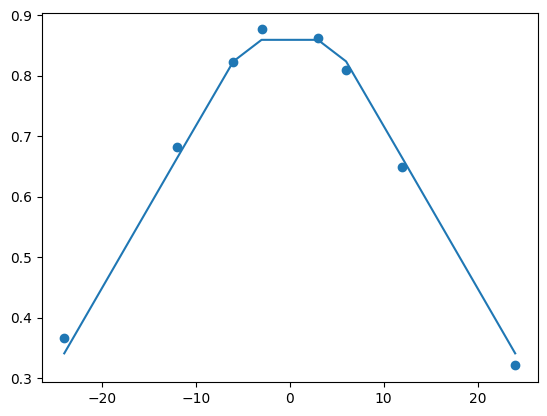

In [6]:
cuppini2017_model_causes_fit = cuppini2017_causes_job(
    cuppini2017_causes_fit_res.x[0],
    cuppini2017_causes_fit_res.x[1],
    cuppini2017_causes_fit_res.x[2],
    cuppini2017_causes_fit_res.x[3],
)

plt.plot(dis, cuppini2017_model_causes_fit)
plt.scatter(dis, causes_data)